# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

In [2]:
os.getcwd()

'C:\\Users\\amakh'

In [3]:
os.chdir("C:\\Users\\amakh\\Downloads")

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [5]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)

import pandas
data = pandas.read_csv('preprocessed_data.csv')
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [6]:
#Checking the column names for the dataset
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [7]:
#Taking "project_is_approved" as y and all other features as x

y = data["project_is_approved"].values
x = data

In [8]:
from sklearn.model_selection import train_test_split
#Taking test data as 30%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(76473, 9) (76473,)
(32775, 9) (32775,)


<h2>1.3 Make Data Model Ready: encoding eassay</h2>

<h3>1.3.1 Applying Bag of Words Vectorization on essay feature</h3>

In [12]:
#BOW on text data

essay_countVectorizer = CountVectorizer(min_df=10,max_features= 5000)
essay_countVectorizer.fit(x_train['essay'].values)


#converting text to vector using vectorizer
x_train_essay_BOW = essay_countVectorizer.transform(x_train['essay'].values)
x_test_essay_BOW = essay_countVectorizer.transform(x_test['essay'].values)

#Checking if the train and test data size remains same after applying encoding

print(x_train_essay_BOW.shape)
print(x_test_essay_BOW.shape)

(76473, 5000)
(32775, 5000)


<h3>1.3.2 Applying TFIDF vectorizer on essay feature</h3>

In [11]:
#TFIDF vectozier on text data
essay_tfidf_vectorizer = TfidfVectorizer(min_df= 10,max_features= 5000)
essay_tfidf_vectorizer.fit(x_train['essay'].values)

#converting text to vector using vectorizer
x_train_essay_tfidf = essay_tfidf_vectorizer.transform(x_train['essay'].values)
x_test_essay_tfidf = essay_tfidf_vectorizer.transform(x_test['essay'].values)

#Checking if the train and test data size remains same after applying encoding

print(x_train_essay_tfidf.shape)
print(x_test_essay_tfidf.shape)

(76473, 5000)
(32775, 5000)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>1.4.1 Encoding of numerical features : teacher_number_of_previously_posted_projects</h3>

In [47]:
#Scaling the numerical features
from sklearn.preprocessing import Normalizer
scaler = Normalizer()

scaler.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

x_train_no_pre_projects_scaled = scaler.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_test_no_pre_projects_scaled = scaler.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

#Checking if the train and test data size remains same after applying normalization

print(x_train_no_pre_projects_scaled.shape)
print(x_test_no_pre_projects_scaled.shape)

(76473, 1)
(32775, 1)


<h3>1.4.2 Encoding of numerical features : price</h3>

In [49]:
#Scaling the numerical features

scaler = Normalizer()

normalizer.fit(x_train['price'].values.reshape(-1,1))
x_train_price_scaled = normalizer.transform(x_train['price'].values.reshape(-1,1))
x_test_price_scaled = normalizer.transform(x_test['price'].values.reshape(-1,1))

#Checking if the train and test data size remains same after applying normalization

print(x_train_price_scaled.shape)
print(x_test_price_scaled.shape)

(76473, 1)
(32775, 1)


<h3>1.4.3 Encoding of categorical features : school_state</h3>

In [15]:
#Performing one hot encoding on categorical features
vectorizer = CountVectorizer()
x_train_school_state_encoded = vectorizer.fit_transform(x_train['school_state'].values)
x_test_school_state_encoded = vectorizer.fit_transform(x_test['school_state'].values)

#Checking if the train and test data size remains same after applying one hot encoding
print(x_train_school_state_encoded.shape)
print(x_test_school_state_encoded.shape)

(76473, 51)
(32775, 51)


<h3> 1.4.4 Encoding of categorical features : teacher_prefix</h3>

In [20]:
#Performing one hot encoding on categorical features

vectorizer = CountVectorizer()
x_train_teacher_prefix_encoded = vectorizer.fit_transform(x_train['teacher_prefix'].values)
x_test_teacher_prefix_encoded = vectorizer.fit_transform(x_test['teacher_prefix'].values)

#Checking if the train and test data size remains same after applying one hot encoding
print(x_train_teacher_prefix_encoded.shape)
print(x_test_teacher_prefix_encoded.shape)

(76473, 5)
(32775, 5)


<h3> 1.4.5 Encoding of categorical features : project_grade_category</h3>

In [21]:
#Performing one hot encoding on categorical features

vectorizer = CountVectorizer()

x_train_project_grade_category_encoded = vectorizer.fit_transform(x_train['project_grade_category'].values)
x_test_project_grade_category_encoded = vectorizer.fit_transform(x_test['project_grade_category'].values)

#Checking if the train and test data size remains same after applying one hot encoding
print(x_train_project_grade_category_encoded.shape)
print(x_test_project_grade_category_encoded.shape)

(76473, 4)
(32775, 4)


<h3> 1.4.6 Encoding of categorical features : clean_categories</h3>

In [23]:
#Performing one hot encoding on categorical features

vectorizer = CountVectorizer()

x_train_clean_categories_encoded = vectorizer.fit_transform(x_train['clean_categories'].values)
x_test_clean_categories_encoded = vectorizer.fit_transform(x_test['clean_categories'].values)

#Checking if the train and test data size remains same after applying one hot encoding
print(x_train_clean_categories_encoded.shape)
print(x_test_clean_categories_encoded.shape)

(76473, 9)
(32775, 9)


<h3> 1.4.7 Encoding of categorical features : clean_subcategories</h3>

In [24]:
#Performing one hot encoding on categorical features

vectorizer = CountVectorizer()

x_train_clean_subcategories_encoded = vectorizer.fit_transform(x_train['clean_subcategories'].values)
x_test_clean_subcategories_encoded = vectorizer.fit_transform(x_test['clean_subcategories'].values)

#Checking if the train and test data size remains same after applying one hot encoding
print(x_train_clean_subcategories_encoded.shape)
print(x_test_clean_subcategories_encoded.shape)

(76473, 30)
(32775, 30)


<h2>1.5 Concatenating features : Set 1 (categorical, numerical features + essay (BOW) </h2>

In [50]:
#Using hstack to conact the features
from scipy.sparse import hstack
x_train_set1 = hstack((x_train_essay_BOW,x_train_no_pre_projects_scaled,x_train_price_scaled,x_train_school_state_encoded,x_train_teacher_prefix_encoded,x_train_project_grade_category_encoded,x_train_clean_categories_encoded,x_train_clean_subcategories_encoded)).tocsr()
x_test_set1 = hstack((x_test_essay_BOW,x_test_no_pre_projects_scaled,x_test_price_scaled,x_test_school_state_encoded,x_test_teacher_prefix_encoded,x_test_project_grade_category_encoded,x_test_clean_categories_encoded,x_test_clean_subcategories_encoded)).tocsr()

print("Concated Data Matrix")

print(x_train_set1.shape,y_train.shape)
print(x_test_set1.shape,y_test.shape)

Concated Data Matrix
(76473, 5101) (76473,)
(32775, 5101) (32775,)


<h2>1.8 hyper paramter tuning on Set 1</h2>

In [76]:
from sklearn.model_selection import GridSearchCV

#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
from sklearn.naive_bayes import MultinomialNB
NB_1 = MultinomialNB(class_prior=[0.5,0.5])

#Taking alpha  as the parameters for GridSearchCV
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100,500,1000]

parameters = {"alpha" :[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100,500,1000]}

clf_1 = GridSearchCV(NB_1, parameters, cv=5, scoring='roc_auc',return_train_score = True)
clf_1.fit(x_train_set1,y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [77]:
#interpreting the results of GridSearchCV
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 

print("best score :",clf_1.best_score_)
print("best parameter:",clf_1.best_params_)

best score : 0.7034265123258987
best parameter: {'alpha': 0.005}


In [78]:
#Checking the Train and Test AUC scores
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

print('Train AUC scores:')
print(clf_1.cv_results_['mean_train_score'])

print('Test AUC scores:')
print(clf_1.cv_results_['mean_test_score'])

Train AUC scores:
[0.74032293 0.74032066 0.74032222 0.74030881 0.7403192  0.74020746
 0.74029697 0.74009785 0.73922269 0.73811573 0.72875167 0.7165929
 0.64994209 0.61665281 0.51122423 0.50030672]
Test AUC scores:
[0.70337368 0.70341057 0.70339466 0.70342651 0.70341692 0.70338232
 0.70342464 0.70331848 0.70276702 0.70205447 0.69540357 0.6860098
 0.63138025 0.60413399 0.51033842 0.50022384]


In [79]:
#creating dataframe to summarize the results of GridSearchCV
results = pd.DataFrame.from_dict(clf_1.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.121010,0.008071,0.015630,7.539457e-07,1e-05,{'alpha': 1e-05},0.702077,0.702394,0.704445,0.706434,...,0.703374,0.001822,7,0.740097,0.739725,0.740390,0.741244,0.740158,0.740323,0.000508
1,0.128505,0.005597,0.015630,5.560829e-07,0.0005,{'alpha': 0.0005},0.702077,0.702391,0.704443,0.706434,...,0.703411,0.001785,4,0.740096,0.739720,0.740387,0.741243,0.740157,0.740321,0.000509
2,0.131330,0.007625,0.012463,6.231797e-03,0.0001,{'alpha': 0.0001},0.702077,0.702393,0.704445,0.706433,...,0.703395,0.001801,5,0.740097,0.739723,0.740389,0.741244,0.740158,0.740322,0.000508
3,0.132676,0.007053,0.009378,7.656953e-03,0.005,{'alpha': 0.005},0.702072,0.702381,0.704435,0.706428,...,0.703427,0.001764,1,0.740086,0.739705,0.740373,0.741233,0.740146,0.740309,0.000510
4,0.121794,0.006198,0.015626,8.358127e-06,0.001,{'alpha': 0.001},0.702076,0.702389,0.704442,0.706433,...,0.703417,0.001778,3,0.740095,0.739718,0.740385,0.741242,0.740156,0.740319,0.000509


<h2>1.9 hyper paramter vs AUC curve </h2>

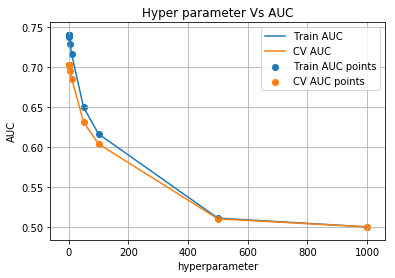

In [81]:
#Plotting hyperparameter(alpha) vs AUC curve

mean_train_score = clf_1.cv_results_['mean_train_score']
mean_test_score = clf_1.cv_results_['mean_test_score']
alpha = results["param_alpha"]
plt.plot(alpha, mean_train_score, label='Train AUC')
plt.plot(alpha, mean_test_score, label='CV AUC')
plt.scatter(alpha, mean_train_score, label='Train AUC points')
plt.scatter(alpha, mean_test_score, label='CV AUC points')
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC")
plt.grid()
plt.show()

<h3>1.10 Finding best parameters and fit the model </h3>

In [82]:
#Finding the best parameters from classifier clf_1

best_alpha= clf_1.best_params_['alpha']
print("alpha= ",best_alpha)

alpha=  0.005


In [83]:
NB_1 = MultinomialNB(class_prior=[0.5,0.5],alpha = 0.005)
NB_1.fit(x_train_set1,y_train)

MultinomialNB(alpha=0.005, class_prior=[0.5, 0.5], fit_prior=True)

<h3>1.11 Plotting ROC-AUC curve </h3>

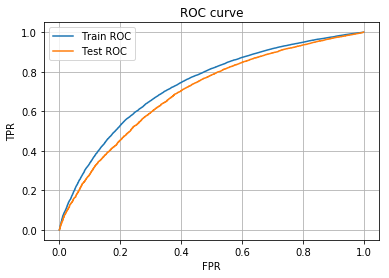

In [85]:
y_train_predicted = NB_1.predict_proba(x_train_set1)[:,1] 
y_test_predicted = NB_1.predict_proba(x_test_set1)[:,1]
ytest_predicted = NB_1.predict(x_test_set1)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_predicted)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_predicted)

plt.plot(train_fpr, train_tpr,label="Train ROC")
plt.plot(test_fpr, test_tpr,label="Test ROC")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()

In [86]:
#Finding the area under curve ROC = AUC

train_AUC = auc(train_fpr, train_tpr)
test_AUC = auc(test_fpr, test_tpr)

print("AUC for train data :",train_AUC)
print("AUC for test data :",test_AUC)

AUC for train data : 0.7338818530968703
AUC for test data : 0.6998742369066834


<h3>1.12 Confusion Matrix </h3>

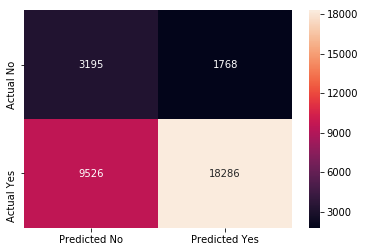

In [88]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, ytest_predicted)
sns.heatmap(cm_test, annot=True,fmt="d",xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actual No','Actual Yes'])

In [89]:
#Getting all the false positive values

false_positive_data = []
for i in range (len(y_test)):
    if (y_test[i] == 0) & (ytest_predicted[i] == 1):
        false_positive_data.append(i)

#checking if the false positive value count matches with that on confusion matrix
print(len(false_positive_data))

1768


In [90]:
#getting the corresponding false positive words from "essay"
false_positive_essay1= []
for i in false_positive_data:
    false_positive_essay1.append(x_test['essay'].values[i])
    
#checking if the false positive value count matches with that on confusion matrix    
print(len(false_positive_essay1))

1768


<h3>1.13 Feature Importances </h3>

In [123]:
#listing down the features using CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer

vectorizer_essay_BOW = CountVectorizer(min_df = 20)
vectorizer_essay_BOW.fit(x_train['essay'].values)

vectorizer_school_state = CountVectorizer(lowercase=False, binary=True)
vectorizer_school_state.fit(x_train['school_state'].values)

vectorizer_teacher_prefix = CountVectorizer(lowercase=False, binary=True)
vectorizer_teacher_prefix.fit(x_train['teacher_prefix'].values)

vectorizer_project_grade_category = CountVectorizer(lowercase=False, binary=True)
vectorizer_project_grade_category.fit(x_train['project_grade_category'].values)

vectorizer_clean_categories = CountVectorizer(lowercase=False, binary=True)
vectorizer_clean_categories.fit(x_train['clean_categories'].values)

vectorizer_clean_subcategories = CountVectorizer(lowercase=False, binary=True)
vectorizer_clean_subcategories.fit(x_train['clean_subcategories'].values)

features_set1 = []
for i in vectorizer_essay_BOW.get_feature_names():
    features_set1.append(i)
for i in vectorizer_school_state.get_feature_names():
    features_set1.append(i)
for i in vectorizer_teacher_prefix.get_feature_names():
    features_set1.append(i)
for i in vectorizer_project_grade_category.get_feature_names():
    features_set1.append(i)
for i in vectorizer_clean_categories.get_feature_names():
    features_set1.append(i)
for i in vectorizer_clean_subcategories.get_feature_names():
    features_set1.append(i)
features_set1.append("price")
features_set1.append("teacher_number_of_previously_posted_projects")

In [124]:
#https://www.py4u.net/discuss/158155
#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
#Getting feature importance using argsort method

neg_class_prob_sorted = NB_1.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = NB_1.feature_log_prob_[1, :].argsort()[::-1]

print("Negative Features : Top 20")
print('*'*25)
print(np.take(features_set1, neg_class_prob_sorted[:20]))

print("Positive Features : Top 20")
print('*'*25)
print(np.take(features_set1, pos_class_prob_sorted[:20]))

Negative Features : Top 20
*************************
['graded' 'flexible' 'delighted' 'dominican' 'attends' 'driving' 'delays'
 'hardcover' 'consumable' 'handshake' 'donations' 'differentiation'
 'ignited' 'download' 'improvisation' 'awkward' 'indicate' 'determines'
 '3rd' 'explorations']
Positive Features : Top 20
*************************
['graded' 'flexible' 'dominican' 'delighted' 'attends' 'handshake'
 'driving' 'hardcover' 'delays' 'consumable' 'differentiation' 'donations'
 'ignited' 'improvisation' 'download' 'explorations' 'horse' 'indicate'
 'determines' 'blessed']


<h2>2.1 Concatenating features : Set 2 (categorical, numerical features + essay (TFIDF) </h2>

In [106]:
#Using hstack to conact the features
from scipy.sparse import hstack
x_train_set2 = hstack((x_train_essay_tfidf,x_train_no_pre_projects_scaled,x_train_price_scaled,x_train_school_state_encoded,x_train_teacher_prefix_encoded,x_train_project_grade_category_encoded,x_train_clean_categories_encoded,x_train_clean_subcategories_encoded)).tocsr()
x_test_set2 = hstack((x_test_essay_tfidf,x_test_no_pre_projects_scaled,x_test_price_scaled,x_test_school_state_encoded,x_test_teacher_prefix_encoded,x_test_project_grade_category_encoded,x_test_clean_categories_encoded,x_test_clean_subcategories_encoded)).tocsr()

print("Concated Data Matrix")

print(x_train_set2.shape,y_train.shape)
print(x_test_set2.shape,y_test.shape)

Concated Data Matrix
(76473, 5101) (76473,)
(32775, 5101) (32775,)


<h2>2.2 hyper paramter tuning on Set 2</h2>

In [108]:
from sklearn.model_selection import GridSearchCV

#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
from sklearn.naive_bayes import MultinomialNB
NB_2 = MultinomialNB(class_prior=[0.5,0.5])

#Taking alpha  as the parameters for GridSearchCV
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100,500,1000]

parameters = {"alpha" :[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100,500,1000]}

clf_2 = GridSearchCV(NB_2, parameters, cv=5, scoring='roc_auc',return_train_score = True)
clf_2.fit(x_train_set2,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [109]:
#interpreting the results of GridSearchCV
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 

print("best score :",clf_2.best_score_)
print("best parameter:",clf_2.best_params_)

best score : 0.6768262488342427
best parameter: {'alpha': 1e-05}


In [110]:
#Checking the Train and Test AUC scores
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

print('Train AUC scores:')
print(clf_2.cv_results_['mean_train_score'])

print('Test AUC scores:')
print(clf_2.cv_results_['mean_test_score'])

Train AUC scores:
[0.71585853 0.71584661 0.71585586 0.7157482  0.71583542 0.71478954
 0.71564099 0.7137312  0.70531526 0.69509396 0.63717504 0.60363528
 0.55332092 0.5441651  0.53701655 0.53737063]
Test AUC scores:
[0.67682625 0.67681866 0.67682447 0.67675258 0.67681076 0.67612002
 0.67668136 0.67541696 0.66948494 0.66181213 0.61557216 0.58819789
 0.5478197  0.54073198 0.53588959 0.53667438]


In [111]:
#creating dataframe to summarize the results of GridSearchCV
results = pd.DataFrame.from_dict(clf_2.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.115307,0.007972,0.015630,0.000002,1e-05,{'alpha': 1e-05},0.671511,0.676239,0.677755,0.678983,...,0.676826,0.002900,1,0.716906,0.714907,0.716095,0.715900,0.715485,0.715859,0.000663
1,0.128625,0.004298,0.011112,0.005773,0.0005,{'alpha': 0.0005},0.671504,0.676236,0.677743,0.678976,...,0.676819,0.002899,3,0.716896,0.714893,0.716080,0.715889,0.715475,0.715847,0.000664
2,0.125037,0.000002,0.015631,0.000002,0.0001,{'alpha': 0.0001},0.671509,0.676239,0.677751,0.678982,...,0.676824,0.002900,2,0.716904,0.714903,0.716091,0.715898,0.715483,0.715856,0.000664
3,0.115628,0.007602,0.012500,0.006250,0.005,{'alpha': 0.005},0.671441,0.676163,0.677666,0.678918,...,0.676753,0.002900,5,0.716800,0.714792,0.715979,0.715789,0.715380,0.715748,0.000665
4,0.124994,0.000079,0.009418,0.007690,0.001,{'alpha': 0.001},0.671496,0.676227,0.677733,0.678968,...,0.676811,0.002900,4,0.716885,0.714882,0.716068,0.715878,0.715464,0.715835,0.000664


<h2>2.3 hyper paramter vs AUC curve </h2>

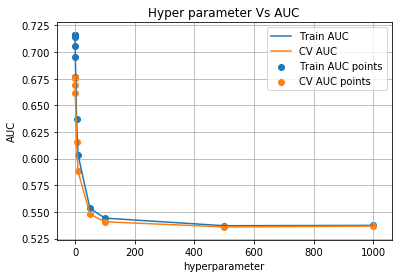

In [112]:
#Plotting hyperparameter(alpha) vs AUC curve

mean_train_score = clf_2.cv_results_['mean_train_score']
mean_test_score = clf_2.cv_results_['mean_test_score']
alpha = results["param_alpha"]
plt.plot(alpha, mean_train_score, label='Train AUC')
plt.plot(alpha, mean_test_score, label='CV AUC')
plt.scatter(alpha, mean_train_score, label='Train AUC points')
plt.scatter(alpha, mean_test_score, label='CV AUC points')
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC")
plt.grid()
plt.show()

<h3>2.4 Finding best parameters and fit the model </h3>

In [113]:
#Finding the best parameters from classifier clf_1

best_alpha= clf_1.best_params_['alpha']
print("alpha= ",best_alpha)

alpha=  1e-05


In [114]:
NB_2 = MultinomialNB(class_prior=[0.5,0.5],alpha = 1e-05)
NB_2.fit(x_train_set2,y_train)

MultinomialNB(alpha=1e-05, class_prior=[0.5, 0.5], fit_prior=True)

<h3>2.5 Plotting ROC-AUC curve </h3>

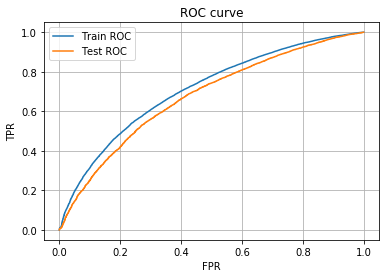

In [115]:
y_train_predicted = NB_2.predict_proba(x_train_set2)[:,1] 
y_test_predicted = NB_2.predict_proba(x_test_set2)[:,1]
ytest_predicted = NB_2.predict(x_test_set2)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_predicted)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_predicted)

plt.plot(train_fpr, train_tpr,label="Train ROC")
plt.plot(test_fpr, test_tpr,label="Test ROC")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()

In [116]:
#Finding the area under curve ROC = AUC

train_AUC = auc(train_fpr, train_tpr)
test_AUC = auc(test_fpr, test_tpr)

print("AUC for train data :",train_AUC)
print("AUC for test data :",test_AUC)

AUC for train data : 0.7092771760077932
AUC for test data : 0.6738653972663929


<h3>2.6 Confusion Matrix </h3>

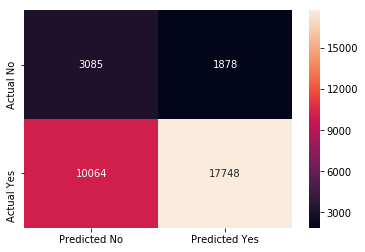

In [118]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, ytest_predicted)
sns.heatmap(cm_test, annot=True,fmt="d",xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actual No','Actual Yes'])

In [119]:
#Getting all the false positive values

false_positive_data = []
for i in range (len(y_test)):
    if (y_test[i] == 0) & (ytest_predicted[i] == 1):
        false_positive_data.append(i)

#checking if the false positive value count matches with that on confusion matrix
print(len(false_positive_data))

1878


In [120]:
#getting the corresponding false positive words from "essay"
false_positive_essay1= []
for i in false_positive_data:
    false_positive_essay1.append(x_test['essay'].values[i])
    
#checking if the false positive value count matches with that on confusion matrix    
print(len(false_positive_essay1))

1878


<h3>2.7 Feature Importances </h3>

In [131]:
#listing down the essay features using TfidfVectorizer
#Other features are already listed

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_essay_tfidf = CountVectorizer(min_df = 20)
vectorizer_essay_tfidf.fit(x_train['essay'].values)

vectorizer_school_state = CountVectorizer(lowercase=False, binary=True)
vectorizer_school_state.fit(x_train['school_state'].values)

vectorizer_teacher_prefix = CountVectorizer(lowercase=False, binary=True)
vectorizer_teacher_prefix.fit(x_train['teacher_prefix'].values)

vectorizer_project_grade_category = CountVectorizer(lowercase=False, binary=True)
vectorizer_project_grade_category.fit(x_train['project_grade_category'].values)

vectorizer_clean_categories = CountVectorizer(lowercase=False, binary=True)
vectorizer_clean_categories.fit(x_train['clean_categories'].values)

vectorizer_clean_subcategories = CountVectorizer(lowercase=False, binary=True)
vectorizer_clean_subcategories.fit(x_train['clean_subcategories'].values)

features_set2 = []
for i in vectorizer_essay_tfidf.get_feature_names():
    features_set2.append(i)
for i in vectorizer_school_state.get_feature_names():
    features_set2.append(i)
for i in vectorizer_teacher_prefix.get_feature_names():
    features_set2.append(i)
for i in vectorizer_project_grade_category.get_feature_names():
    features_set2.append(i)
for i in vectorizer_clean_categories.get_feature_names():
    features_set2.append(i)
for i in vectorizer_clean_subcategories.get_feature_names():
    features_set2.append(i)
features_set2.append("price")
features_set2.append("teacher_number_of_previously_posted_projects")

In [132]:
#https://www.py4u.net/discuss/158155
#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
#Getting feature importance using argsort method

neg_class_prob_sorted = NB_2.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = NB_2.feature_log_prob_[1, :].argsort()[::-1]

print("Negative Features : Top 20")
print('*'*25)
print(np.take(features_set2, neg_class_prob_sorted[:20]))

print("Positive Features : Top 20")
print('*'*25)
print(np.take(features_set2, pos_class_prob_sorted[:20]))

Negative Features : Top 20
*************************
['indicate' 'infusion' 'initial' 'inherently' 'initially' 'ingenuity'
 'ingredients' 'input' 'inquire' 'inputs' 'inhabit' 'graded' 'ins'
 'initiated' 'indigenous' 'inhibit' 'inherit' 'initiatives' 'inherent'
 'infusing']
Positive Features : Top 20
*************************
['indicate' 'infusion' 'initial' 'inherently' 'initially' 'ingenuity'
 'ingredients' 'input' 'inquire' 'inputs' 'inhabit' 'indigenous' 'graded'
 'inhibit' 'ins' 'initiated' 'inherit' 'inherent' 'infusing' 'initiatives']


<h1>3. Summary</h1>


In [133]:
#Tabulating the results using PtrettyTable
#https://pypi.org/project/prettytable/

from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "alpha","test_AUC"]
x.add_row(["BOW", "NB","0.005" ,"0.703"])
x.add_row(["TFIDF", "NB", "1e-05" ,"0.677"])
print(x)

+------------+-------+-------+----------+
| Vectorizer | Model | alpha | test_AUC |
+------------+-------+-------+----------+
|    BOW     |   NB  | 0.005 |  0.703   |
|   TFIDF    |   NB  | 1e-05 |  0.677   |
+------------+-------+-------+----------+
